# **DOA Estimation Simulation**

This notebook demonstrates with multiple sources, snapshot averaging, and robust peak detection.

## **1. Import Libraries**

In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

plt.style.use('seaborn-v0_8')

## **2. Signal Model**

The received signal at an array of $M$ sensors with $K$ sources is:

$$
\mathbf{X}(t) = \mathbf{A}(\theta) \mathbf{S}(t) + \mathbf{N}(t)
$$

Where:
- $\mathbf{X}(t) \in \mathbb{C}^{M \times N}$ — received signal matrix (M sensors, N snapshots)
- $\mathbf{A}(\theta) \in \mathbb{C}^{M \times K}$ — steering matrix

$$
\mathbf{A}(\theta) =
\begin{bmatrix}
1 & 1 & \dots & 1 \\
e^{-j 2 \pi d \sin\theta_1} & e^{-j 2 \pi d \sin\theta_2} & \dots & e^{-j 2 \pi d \sin\theta_K} \\
\vdots & \vdots & \ddots & \vdots \\
e^{-j 2 \pi d (M-1) \sin\theta_1} & e^{-j 2 \pi d (M-1) \sin\theta_2} & \dots & e^{-j 2 \pi d (M-1) \sin\theta_K}
\end{bmatrix}
$$

- $\mathbf{S}(t) \in \mathbb{C}^{K \times N}$ — source signal matrix  
- $\mathbf{N}(t) \in \mathbb{C}^{M \times N}$ — additive noise

## **3. Parameters**

In [56]:
# Array and signal parameters
M = 32 # Number of sensors
d = 0.5 # Sensor spacing (Normalized to wavelength)
angles = np.array([5.0, 5.5, 6, 6.5]) # Source DOAs (degrees)
num_sources = len(angles)

fs = 1000 # Sampling frequency
duration = 1 # Duration (seconds)
t = np.linspace(0, duration, int(fs*duration))  # Time vector

SNR_dB = 100 # Desired SNR at array (dB)

print(f"Number of sensors: {M}, Number of sources: {num_sources}, SNR: {SNR_dB} dB")

Number of sensors: 32, Number of sources: 4, SNR: 100 dB


## **4. Generate Source Signals (Sum of Sinusoids)**

In [57]:
def generate_source_signal(t, freqs_per_source=3, freq_range=(50, 500)):
    freqs = np.random.uniform(freq_range[0], freq_range[1], freqs_per_source)
    signal = np.sum([np.sin(2*np.pi*f*t) for f in freqs], axis=0)
    return signal

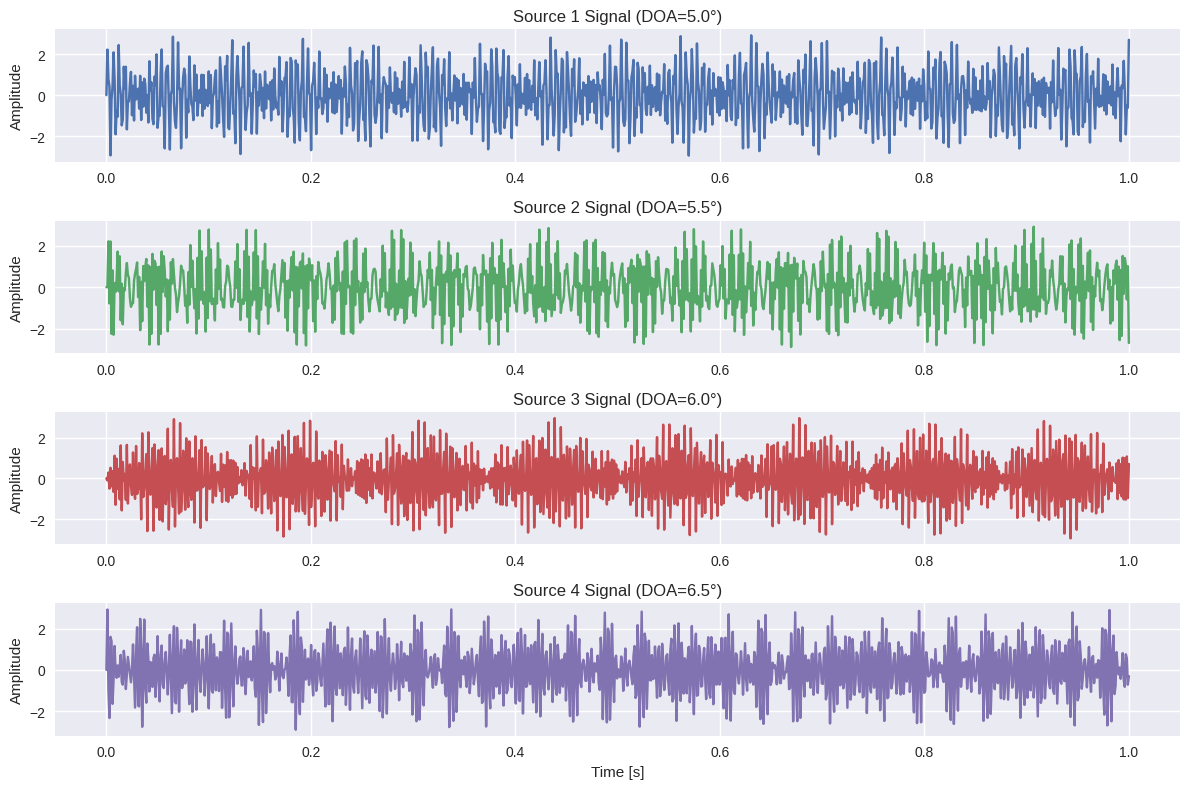

In [58]:
S = np.zeros((num_sources, len(t)))
for i in range(num_sources):
    S[i, :] = generate_source_signal(t, freqs_per_source=3, freq_range=(50, 900))

# Plot source signals
plt.figure(figsize=(12, 8))
for i in range(num_sources):
    plt.subplot(num_sources, 1, i+1)
    plt.plot(t, S[i], color=f'C{i}')
    plt.title(f"Source {i+1} Signal (DOA={angles[i]}°)")
    plt.ylabel("Amplitude")
    plt.grid(True)
plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

## **5. Steering Matrix and Received Signals**

In [59]:
# Steering matrix
A = np.zeros((M, num_sources), dtype=complex)
for i, angle in enumerate(angles):
    theta = np.deg2rad(angle)
    A[:, i] = np.exp(-1j * 2 * np.pi * d * np.arange(M) * np.sin(theta))

# Additive noise
signal_power = np.mean(np.abs(A @ S)**2)
noise_power = signal_power / 10**(SNR_dB/10)
N = np.sqrt(noise_power/2) * (np.random.randn(M, len(t)) + 1j * np.random.randn(M, len(t)))

# Received signals
X = A @ S + N

# Verify shapes
print("Steering matrix A:", A.shape)
print("Source signals S:", S.shape)
print("Noise N:", N.shape)
print("Received signals X:", X.shape)

Steering matrix A: (32, 4)
Source signals S: (4, 1000)
Noise N: (32, 1000)
Received signals X: (32, 1000)


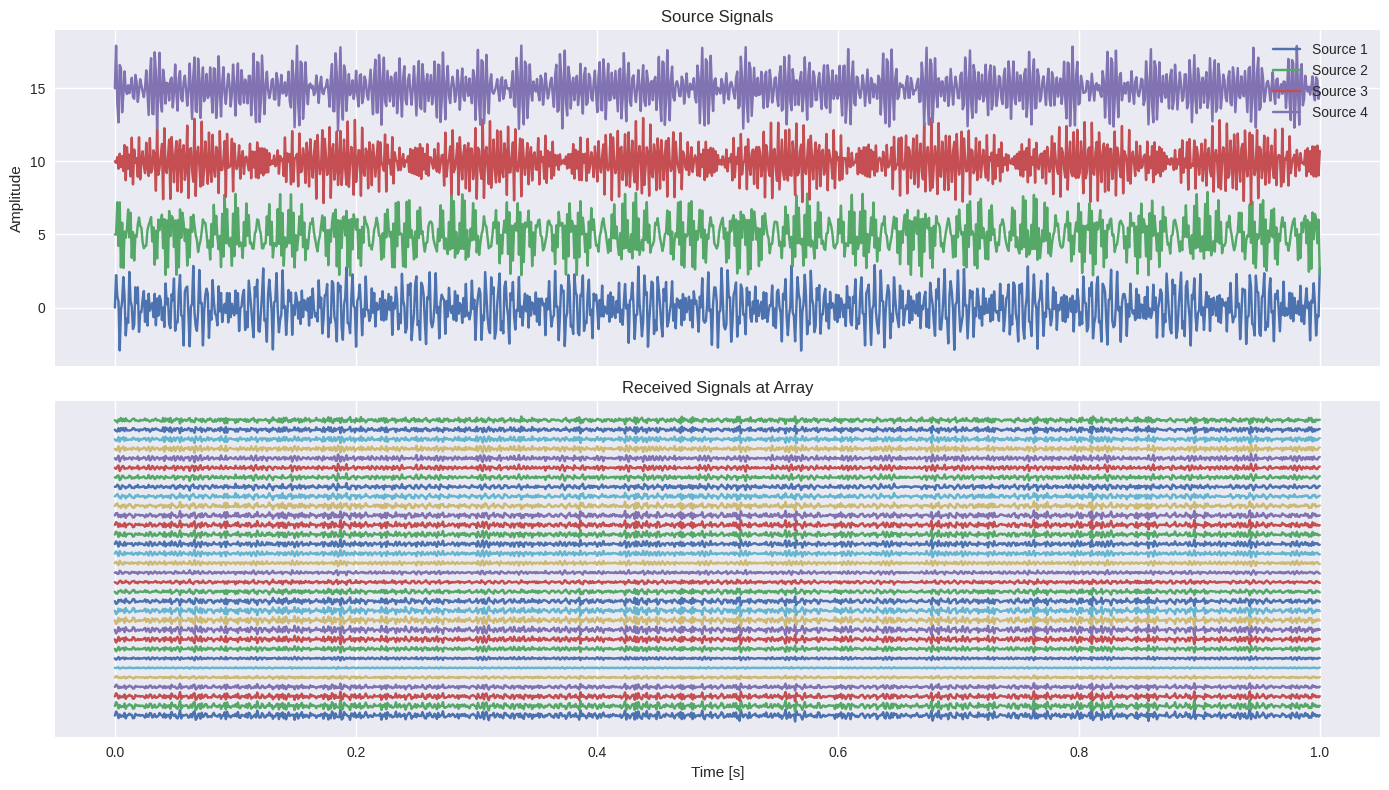

In [60]:
# Plot Received Signals
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Original sources (shifted for clarity)
for i in range(num_sources):
    axs[0].plot(t, S[i] + i*5, label=f"Source {i+1}")
axs[0].set_title("Source Signals")
axs[0].set_ylabel("Amplitude")
axs[0].legend()
axs[0].grid(True)

# Received array signals
offset = 1.5 * np.max(np.abs(X.real))
for m in range(M):
    axs[1].plot(t, X[m].real + m*offset, label=f"Sensor {m+1}")
axs[1].set_title("Received Signals at Array")
axs[1].set_xlabel("Time [s]")
axs[1].set_yticks([])
axs[1].grid(True)

plt.tight_layout()
plt.show()

## **6. Spatial Correlation Matrix**

$$
\mathbf{R}_{xx} = \frac{1}{N} \mathbf{X} \mathbf{X}^H
$$

In [61]:
Rxx = (X @ X.conj().T) / X.shape[1]
Rxx_df = pd.DataFrame(np.abs(Rxx))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(Rxx_df)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
0,5.950291,5.947532,5.939256,5.925478,5.906218,5.881506,5.851376,5.815883,5.775069,5.729009,5.677760,5.621409,5.560039,5.493742,5.422620,5.346778,5.266341,5.181415,5.092145,4.998657,4.901094,4.799602,4.694337,4.585455,4.473122,4.357506,4.238781,4.117125,3.992722,3.865754,3.736411,3.604893
1,5.947532,5.950312,5.947571,5.939315,5.925556,5.906315,5.881618,5.851513,5.816032,5.775242,5.729193,5.677964,5.621629,5.560274,5.493992,5.422882,5.347061,5.266628,5.181722,5.092462,4.998985,4.901431,4.799949,4.694691,4.585816,4.473489,4.357878,4.239157,4.117506,3.993103,3.866134,3.736795
2,5.939256,5.947571,5.950369,5.947648,5.939410,5.925670,5.906445,5.881773,5.851679,5.816222,5.775444,5.729415,5.678201,5.621881,5.560541,5.494271,5.423181,5.347364,5.266951,5.182055,5.092805,4.999337,4.901793,4.800318,4.695067,4.586199,4.473877,4.358270,4.239554,4.117902,3.993498,3.866533
3,5.925478,5.939315,5.947648,5.950465,5.947762,5.939544,5.925820,5.906619,5.881958,5.851889,5.816443,5.775684,5.729670,5.678472,5.622167,5.560838,5.494589,5.423503,5.347706,5.267302,5.182417,5.093176,4.999718,4.902180,4.800712,4.695468,4.586604,4.474286,4.358684,4.239967,4.118314,3.993914
4,5.906218,5.925556,5.939410,5.947762,5.950598,5.947915,5.939712,5.926013,5.906823,5.882186,5.852128,5.816702,5.775958,5.729960,5.678776,5.622482,5.561174,5.494928,5.423862,5.348075,5.267682,5.182805,5.093574,5.000122,4.902592,4.801130,4.695890,4.587030,4.474717,4.359114,4.240395,4.118747
5,5.881506,5.906315,5.925670,5.939544,5.947915,5.950771,5.948103,5.939925,5.926236,5.907071,5.882446,5.852407,5.816996,5.776268,5.730284,5.679112,5.622839,5.561534,5.495308,5.424252,5.348475,5.268091,5.183224,5.093999,5.000554,4.903030,4.801573,4.696337,4.587482,4.475168,4.359563,4.240849
6,5.851376,5.881618,5.906445,5.925820,5.939712,5.948103,5.950973,5.948330,5.940163,5.926498,5.907345,5.882739,5.852715,5.817320,5.776606,5.730633,5.679481,5.623212,5.561927,5.495711,5.424665,5.348897,5.268523,5.183661,5.094444,5.001005,4.903485,4.802031,4.696800,4.587945,4.475628,4.360028
7,5.815883,5.851513,5.881773,5.906619,5.926013,5.939925,5.948330,5.951225,5.948593,5.940450,5.926797,5.907662,5.883071,5.853063,5.817681,5.776979,5.731026,5.679878,5.623628,5.562353,5.496147,5.425110,5.349351,5.268982,5.184128,5.094916,5.001481,4.903965,4.802517,4.697284,4.588426,4.476114
8,5.775069,5.816032,5.851679,5.881958,5.906823,5.926236,5.940163,5.948593,5.951499,5.948890,5.940759,5.927125,5.908005,5.883430,5.853436,5.818066,5.777383,5.731435,5.680306,5.624065,5.562800,5.496603,5.425575,5.349822,5.269461,5.184612,5.095405,5.001974,4.904463,4.803013,4.697778,4.588925
9,5.729009,5.775242,5.816222,5.851889,5.882186,5.907071,5.926498,5.940450,5.948890,5.951820,5.949223,5.941110,5.927491,5.908387,5.883825,5.853842,5.818492,5.777813,5.731884,5.680764,5.624534,5.563277,5.497089,5.426067,5.350321,5.269965,5.185121,5.095916,5.002490,4.904978,4.803525,4.698295


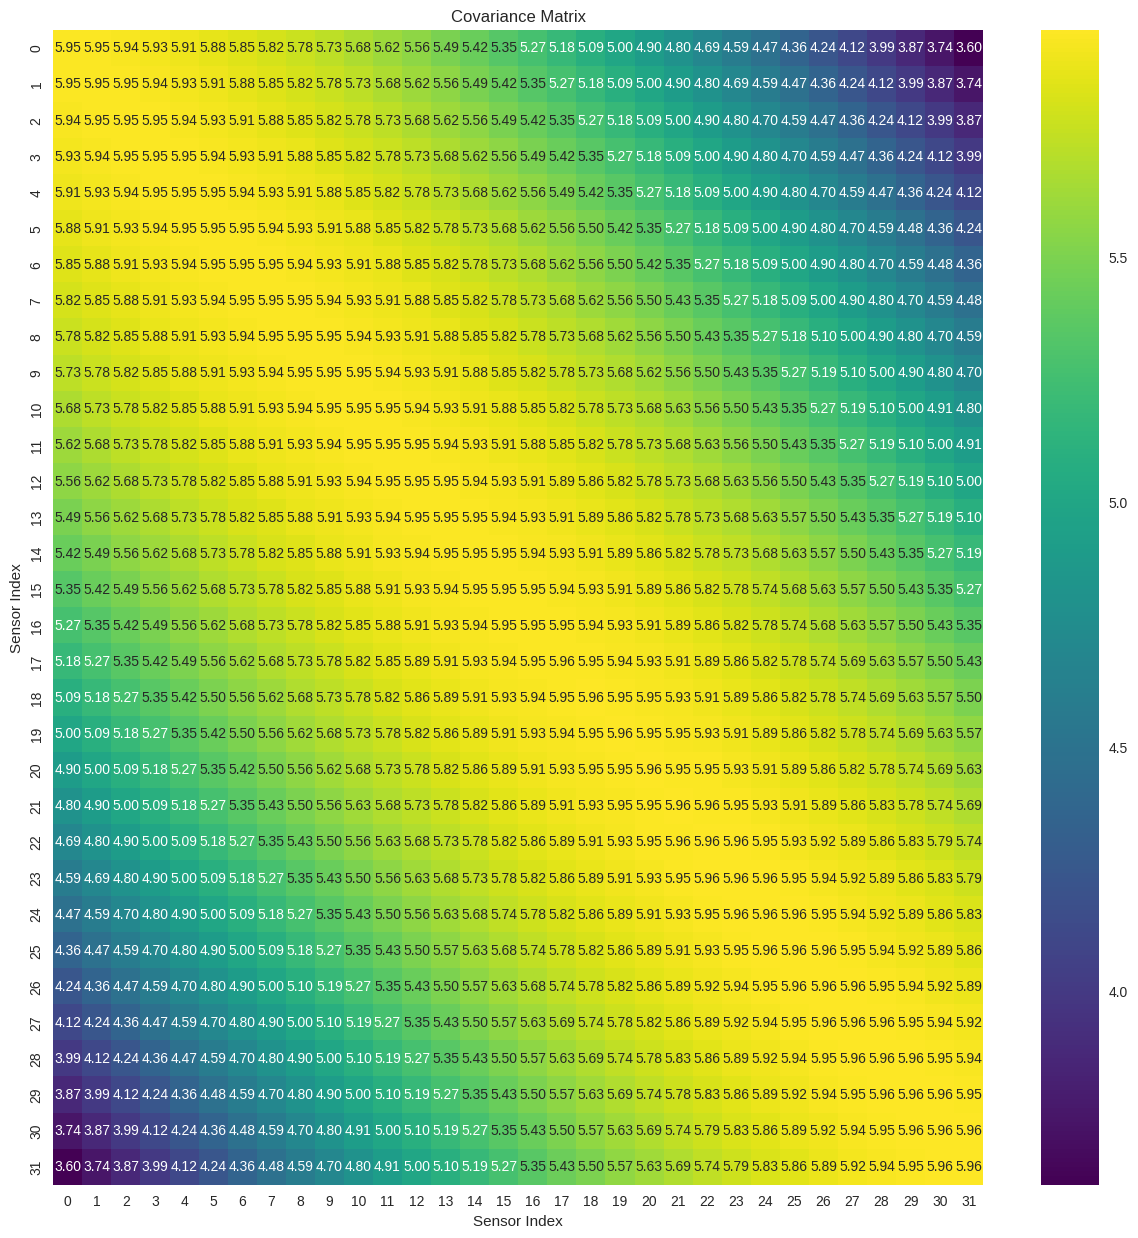

In [62]:
# Plot covariance matrix heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(np.abs(Rxx), annot=True, fmt=".2f", cmap='viridis')
plt.title("Covariance Matrix")
plt.xlabel("Sensor Index")
plt.ylabel("Sensor Index")
plt.show()

## **7. MUSIC DOA Estimation**

The MUSIC spatial spectrum:

$$
P_{\text{MUSIC}}(\theta) = \frac{1}{\mathbf{a}(\theta)^H \mathbf{E}_n \mathbf{E}_n^H \mathbf{a}(\theta)}
$$

Where:
- $\mathbf{a}(\theta)$ — steering vector for angle $\theta$
- $\mathbf{E}_n$ — noise subspace (eigenvectors of smallest eigenvalues of $\mathbf{R}_{xx}$)

In [63]:
# Function for MUSIC DOA Estimation
def music_doa_estimation(X, num_sources, d=0.5, scan_angles=np.arange(-90, 91, 0.1)):
    M, N = X.shape
    Rxx = (X @ X.conj().T) / N
    eigvals, eigvecs = np.linalg.eigh(Rxx)  # eigh for Hermitian
    idx = eigvals.argsort()[::-1]
    eigvecs = eigvecs[:, idx]
    En = eigvecs[:, num_sources:]  # Noise subspace

    P_music = []
    for angle in scan_angles:
        theta = np.deg2rad(angle)
        a = np.exp(-1j * 2 * np.pi * d * np.arange(M) * np.sin(theta)).reshape(-1,1)
        P = 1 / np.abs(a.conj().T @ En @ En.conj().T @ a)
        P_music.append(P[0,0].real)

    return np.array(scan_angles), np.array(P_music)

# Snapshot-Averaged MUSIC Estimation
def snapshot_averaged_music(X, num_sources, N_snapshots=5, scan_angles=np.arange(-90, 91, 0.1)):
    M, total_samples = X.shape
    P_avg = None
    for n in range(N_snapshots):
        start = n*(total_samples//N_snapshots)
        end = (n+1)*(total_samples//N_snapshots)
        X_snap = X[:, start:end]
        _, P_music = music_doa_estimation(X_snap, num_sources, scan_angles=scan_angles)
        if P_avg is None:
            P_avg = P_music
        else:
            P_avg += P_music
    P_avg /= N_snapshots
    return scan_angles, P_avg

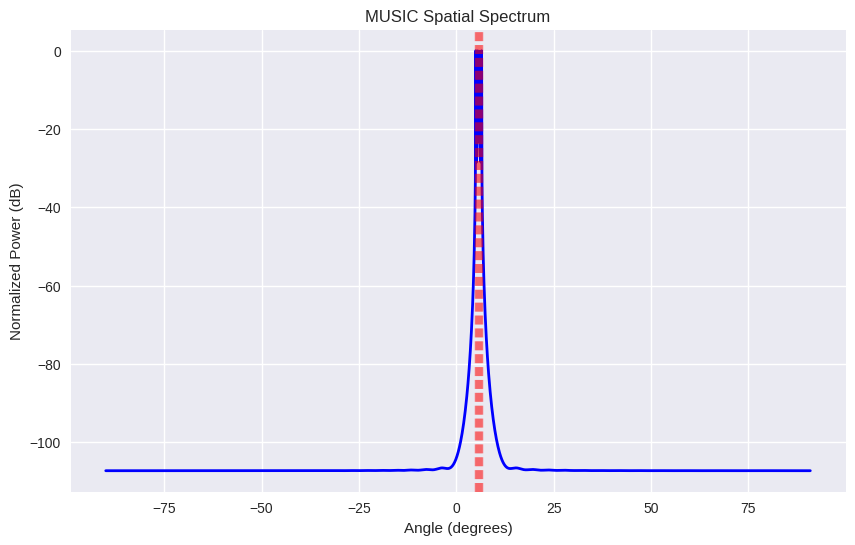

In [64]:
scan_angles, P_music_avg = snapshot_averaged_music(X, num_sources, N_snapshots=50)

# Plot MUSIC Spectrum
plt.figure(figsize=(10,6))
plt.plot(scan_angles, 10*np.log10(P_music_avg/np.max(P_music_avg)), linewidth=2, color='b')
for angle in angles:
    plt.axvline(x=angle, color='r', linestyle='--', alpha=0.5)
plt.title("MUSIC Spatial Spectrum")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.grid(True)
plt.show()

In [65]:
# Find peaks
peaks, properties = find_peaks(
    P_music_avg,
    height=np.mean(P_music_avg) + 2 * np.std(P_music_avg),  # Adaptive threshold
)
estimated_DOAs = scan_angles[peaks]

# Handle missed detections by checking lengths
if len(estimated_DOAs) < len(angles):
    estimated_DOAs = np.append(estimated_DOAs, [0]*(len(angles) - len(estimated_DOAs)))
    print("Warning: Some DOAs were not detected; added zeros for missed detections.")

# Convert to floats and sort
estimated_DOAs_clean = [float(np.round(angle,2)) for angle in estimated_DOAs]
original_DOAs_clean = [float(angle) for angle in angles]

print("Estimated DOAs (degrees):", sorted(estimated_DOAs_clean))
print("Original DOAs (degrees):", sorted(original_DOAs_clean))

Estimated DOAs (degrees): [5.0, 5.5, 6.0, 6.5]
Original DOAs (degrees): [5.0, 5.5, 6.0, 6.5]


In [66]:
def calculate_rmse_mse(estimated_DOAs_clean, original_DOAs_clean):
    try:
        # Compute RMSE / MSE
        rmse = np.sqrt(np.mean((np.sort(estimated_DOAs_clean) - np.sort(original_DOAs_clean))**2))
        mse = np.mean((np.sort(estimated_DOAs_clean) - np.sort(original_DOAs_clean))**2)
        print(f"RMSE: {rmse:.2f}°, MSE: {mse:.2f}°")
    except ValueError:
        print("Error in RMSE/MSE calculation: Mismatched number of estimated and original DOAs.")

In [67]:
calculate_rmse_mse(estimated_DOAs_clean, original_DOAs_clean)

RMSE: 0.00°, MSE: 0.00°


## **8. Capon (MVDR) DOA Estimation**

Capon (MVDR) spatial spectrum:

$$
P_\text{Capon}(\theta) = \frac{1}{\mathbf{a}(\theta)^H \mathbf{R}_{xx}^{-1} \mathbf{a}(\theta)}
$$
where $\mathbf{R}_{xx}$ is the spatial correlation matrix.

In [68]:
# Function for Capon DOA Estimation
def capon_doa_estimation(X, d=0.5, scan_angles=np.arange(-90,91,0.1)):
    M, N = X.shape
    Rxx = (X @ X.conj().T) / N        # Spatial correlation matrix
    Rxx_inv = np.linalg.pinv(Rxx)     # Pseudo-inverse for stability
    P_capon = []
    for angle in scan_angles:
        theta = np.deg2rad(angle)
        a = np.exp(-1j*2*np.pi*d*np.arange(M)*np.sin(theta)).reshape(-1,1)
        P = 1 / np.real(a.conj().T @ Rxx_inv @ a)
        P_capon.append(P[0,0])
    return np.array(scan_angles), np.array(P_capon)

# Snapshot-Averaged Capon
def snapshot_averaged_capon(X, N_snapshots=5, d=0.5, scan_angles=np.arange(-90,91,0.1)):
    M, total_samples = X.shape
    P_avg = None
    for n in range(N_snapshots):
        start = n*(total_samples//N_snapshots)
        end = (n+1)*(total_samples//N_snapshots)
        X_snap = X[:, start:end]
        _, P = capon_doa_estimation(X_snap, d=d, scan_angles=scan_angles)
        if P_avg is None:
            P_avg = P
        else:
            P_avg += P
    P_avg /= N_snapshots
    return scan_angles, P_avg

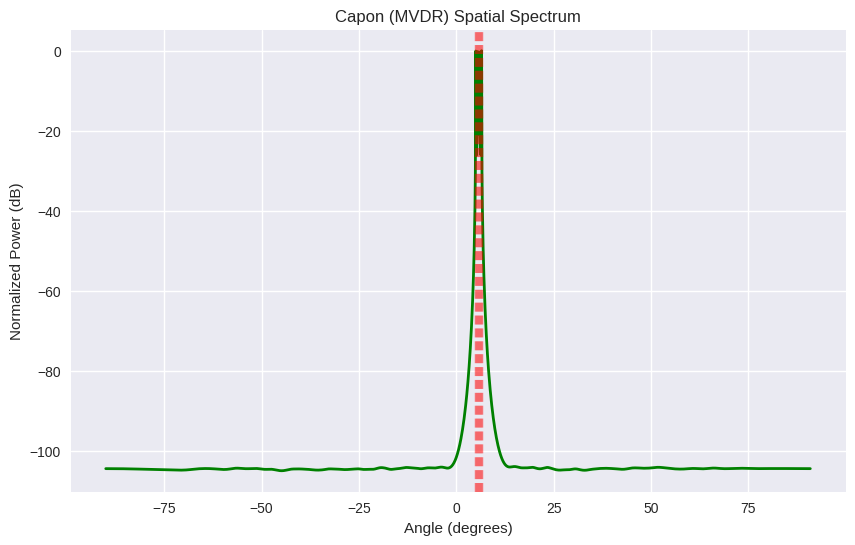

In [69]:
scan_angles, P_capon_avg = snapshot_averaged_capon(X, N_snapshots=50)

# Plot Capon Spectrum
plt.figure(figsize=(10,6))
plt.plot(scan_angles, 10*np.log10(P_capon_avg/np.max(P_capon_avg)), linewidth=2, color='g')
for angle in angles:
    plt.axvline(x=angle, color='r', linestyle='--', alpha=0.5)
plt.title("Capon (MVDR) Spatial Spectrum")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.grid(True)
plt.show()


In [70]:
# Detect peaks
peaks, properties = find_peaks(
    P_music_avg,
    height=np.mean(P_music_avg) + 2 * np.std(P_music_avg),  # Adaptive threshold
)
estimated_DOAs = scan_angles[peaks]

# Handle missed detections by checking lengths
if len(estimated_DOAs) < len(angles):
    estimated_DOAs = np.append(estimated_DOAs, [0]*(len(angles) - len(estimated_DOAs)))
    print("Warning: Some DOAs were not detected; added zeros for missed detections.")

# Sort and convert to floats
estimated_DOAs_clean = [float(np.round(angle,2)) for angle in estimated_DOAs]
original_DOAs_clean = [float(angle) for angle in angles]

print("Estimated DOAs (degrees):", sorted(estimated_DOAs_clean))
print("Original DOAs (degrees):", sorted(original_DOAs_clean))

Estimated DOAs (degrees): [5.0, 5.5, 6.0, 6.5]
Original DOAs (degrees): [5.0, 5.5, 6.0, 6.5]


In [71]:
# Compute RMSE / MSE
calculate_rmse_mse(estimated_DOAs_clean, original_DOAs_clean)

RMSE: 0.00°, MSE: 0.00°


## **Comparison Between MUSIC and Capon**

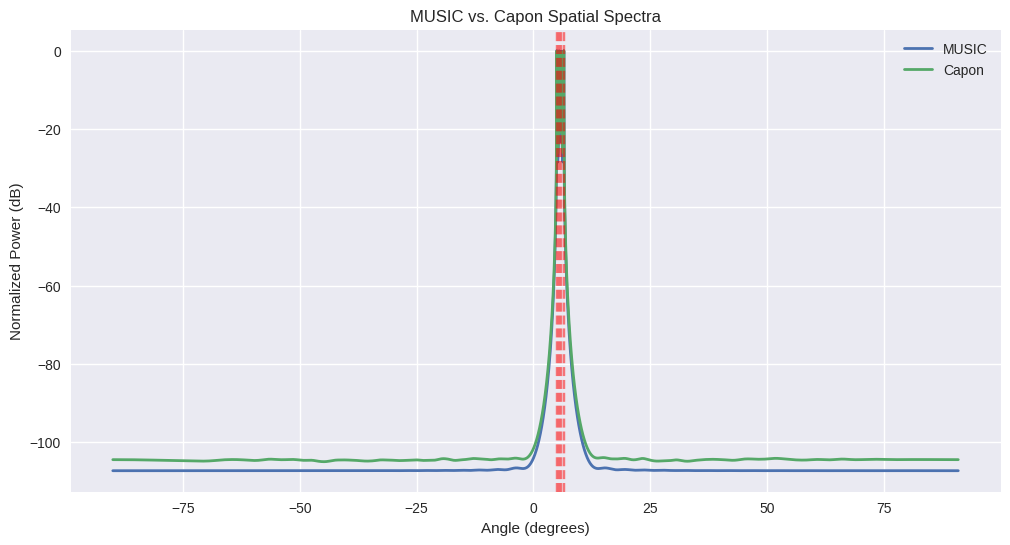

In [72]:
# Plot MUSIC and Capon Spectra Together
plt.figure(figsize=(12, 6))
plt.plot(scan_angles, 10 * np.log10(P_music_avg / np.max(P_music_avg)), label='MUSIC', linewidth=2)
plt.plot(scan_angles, 10 * np.log10(P_capon_avg / np.max(P_capon_avg)), label='Capon', linewidth=2)
for angle in angles:
    plt.axvline(x=angle, color='r', linestyle='--', alpha=0.5)
plt.title("MUSIC vs. Capon Spatial Spectra")
plt.xlabel("Angle (degrees)")
plt.ylabel("Normalized Power (dB)")
plt.legend()
plt.grid(True)
plt.show()